Please upload crop.csv


Saving crop.csv to crop.csv


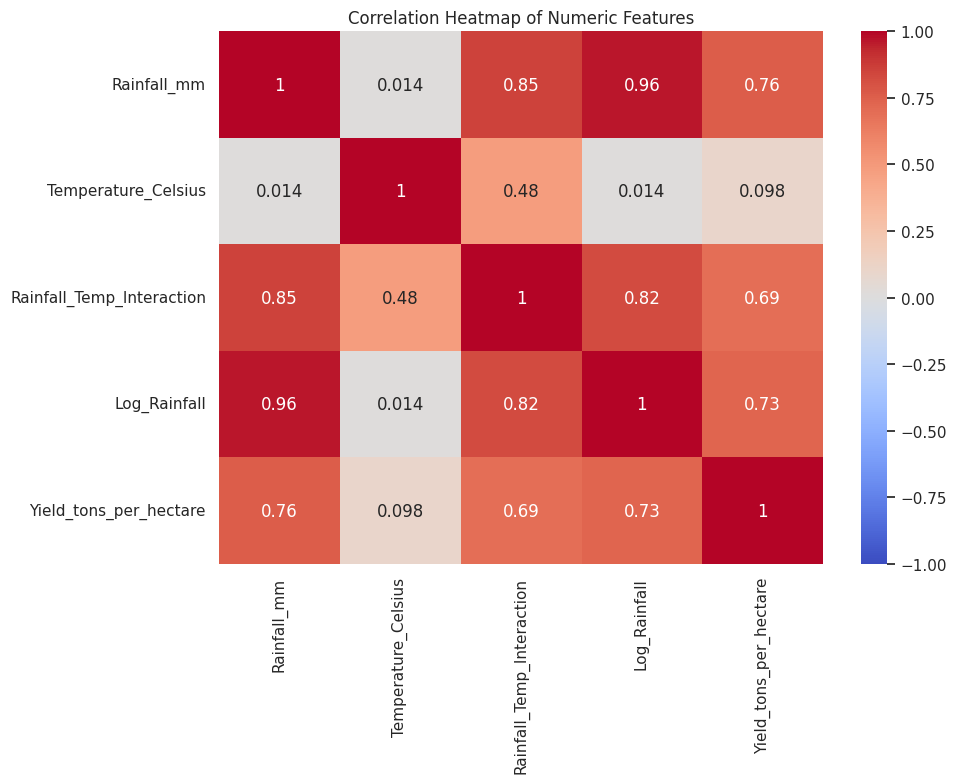

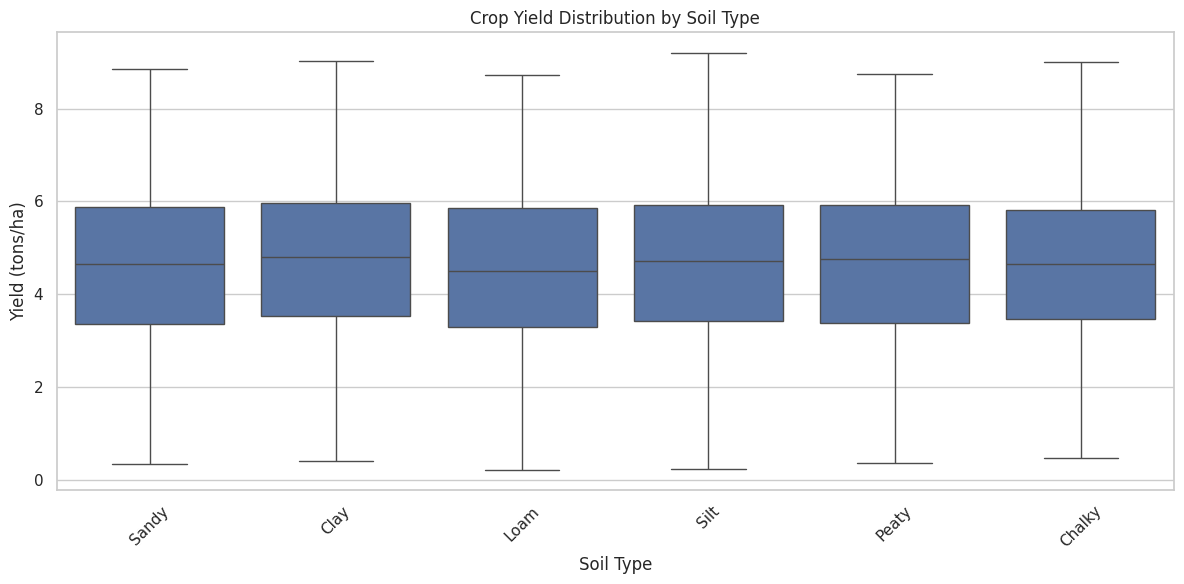

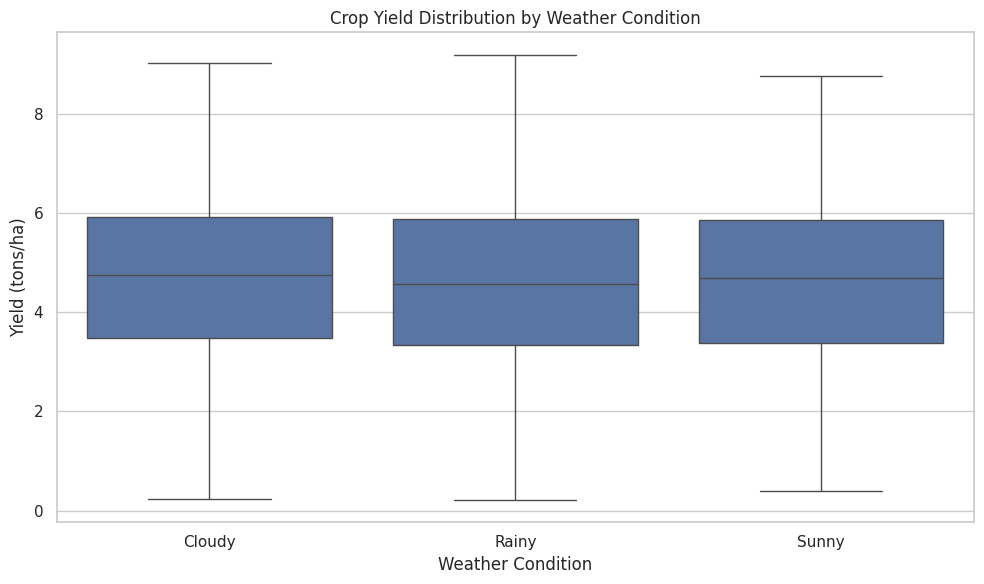

Random Forest Performance:
Mean Squared Error: 1.40
R² Score: 0.53



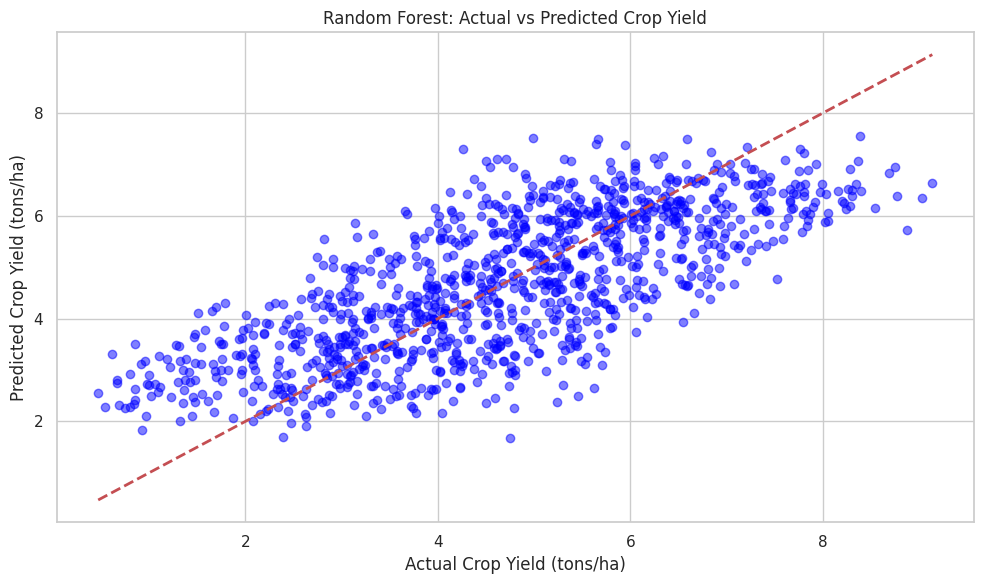

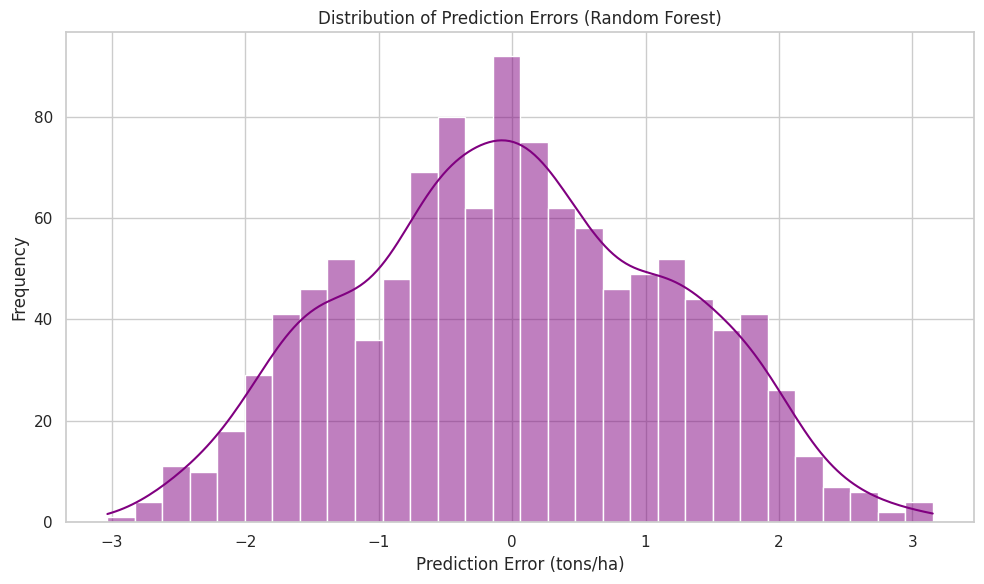

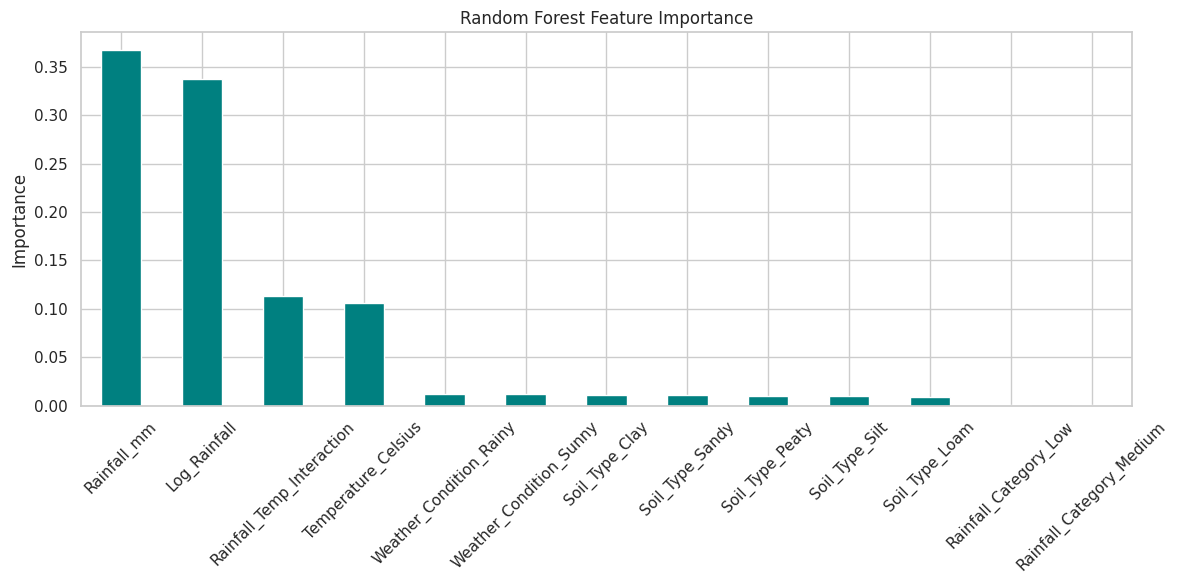


Enter the following details for crop yield prediction:
Rainfall (mm, e.g., 100-1000): 500
Temperature (°C, e.g., 10-40): 37
Soil Types: ['Sandy', 'Clay', 'Loam', 'Silt', 'Peaty', 'Chalky']
Soil Type (e.g., Clay): sandy
Weather Conditions: ['Sunny', 'Cloudy', 'Rainy']
Weather Condition (e.g., Sunny): rainy

Predicted Crop Yield: 4.30 tons/ha

Would you like to make another prediction? (yes/no): no
Thank you for using the Crop Yield Prediction System!


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files

# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Step 1: Upload the dataset
print("Please upload crop.csv")
uploaded = files.upload()

# Load the dataset
data = pd.read_csv('crop.csv')

# Step 2: Expanded Preprocessing
# 2.1: Handle missing values
data = data.dropna()

# 2.2: Convert boolean columns to strings for consistency
data['Fertilizer_Used'] = data['Fertilizer_Used'].astype(str)
data['Irrigation_Used'] = data['Irrigation_Used'].astype(str)

# 2.3: Outlier detection and handling
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['Rainfall_mm', 'Temperature_Celsius']:
    data = remove_outliers(data, col)

# 2.4: Feature engineering
data['Rainfall_Temp_Interaction'] = data['Rainfall_mm'] * data['Temperature_Celsius']
data['Log_Rainfall'] = np.log1p(data['Rainfall_mm'])
bins = [0, 300, 600, 1000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']
data['Rainfall_Category'] = pd.cut(data['Rainfall_mm'], bins=bins, labels=labels, include_lowest=True)

# 2.5: Check for invalid values
data = data[data['Yield_tons_per_hectare'] >= 0]

# 2.6: Visualization 1 - Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data[['Rainfall_mm', 'Temperature_Celsius', 'Rainfall_Temp_Interaction',
                          'Log_Rainfall', 'Yield_tons_per_hectare']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()

# 2.7: Visualization 2 - Box Plot of Yield by Soil Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Soil_Type', y='Yield_tons_per_hectare', data=data)
plt.title('Crop Yield Distribution by Soil Type')
plt.xlabel('Soil Type')
plt.ylabel('Yield (tons/ha)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('yield_by_soil_type.png')
plt.close()

# 2.8: Visualization 3 - Box Plot of Yield by Weather Condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather_Condition', y='Yield_tons_per_hectare', data=data)
plt.title('Crop Yield Distribution by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Yield (tons/ha)')
plt.tight_layout()
plt.show()
plt.savefig('yield_by_weather_condition.png')
plt.close()

# 2.9: Define features and target
X = data[['Rainfall_mm', 'Temperature_Celsius', 'Soil_Type', 'Weather_Condition',
          'Rainfall_Temp_Interaction', 'Log_Rainfall', 'Rainfall_Category']]
y = data['Yield_tons_per_hectare']

# 2.10: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.11: Create preprocessing pipeline
numeric_features = ['Rainfall_mm', 'Temperature_Celsius', 'Rainfall_Temp_Interaction', 'Log_Rainfall']
categorical_features = ['Soil_Type', 'Weather_Condition', 'Rainfall_Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Step 3: Create and train Random Forest model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# Step 4: Evaluate model
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}\n")
    return y_pred

rf_pred = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

# Step 5: Visualization 4 - Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Crop Yield (tons/ha)')
plt.ylabel('Predicted Crop Yield (tons/ha)')
plt.title('Random Forest: Actual vs Predicted Crop Yield')
plt.tight_layout()
plt.show()
plt.savefig('crop_yield_prediction.png')
plt.close()

# Step 6: Visualization 5 - Prediction Error Plot
errors = y_test - rf_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title('Distribution of Prediction Errors (Random Forest)')
plt.xlabel('Prediction Error (tons/ha)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.savefig('prediction_error.png')
plt.close()

# Step 7: Visualization 6 - Feature Importance
rf_model = rf_pipeline.named_steps['regressor']
feature_names = (
    numeric_features +
    list(rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
)
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar', color='teal')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()

# Step 8: Interactive User Input for Prediction
def get_user_input():
    print("\nEnter the following details for crop yield prediction:")

    while True:
        try:
            rainfall = float(input("Rainfall (mm, e.g., 100-1000): "))
            if 0 <= rainfall <= 2000:
                break
            else:
                print("Please enter a value between 0 and 2000.")
        except ValueError:
            print("Please enter a valid number.")

    while True:
        try:
            temperature = float(input("Temperature (°C, e.g., 10-40): "))
            if 0 <= temperature <= 50:
                break
            else:
                print("Please enter a value between 0 and 50.")
        except ValueError:
            print("Please enter a valid number.")

    valid_soils = ['Sandy', 'Clay', 'Loam', 'Silt', 'Peaty', 'Chalky']
    print("Soil Types:", valid_soils)
    while True:
        soil_type = input("Soil Type (e.g., Clay): ").strip().capitalize()
        if soil_type in valid_soils:
            break
        else:
            print(f"Please choose from {valid_soils}.")

    valid_weather = ['Sunny', 'Cloudy', 'Rainy']
    print("Weather Conditions:", valid_weather)
    while True:
        weather = input("Weather Condition (e.g., Sunny): ").strip().capitalize()
        if weather in valid_weather:
            break
        else:
            print(f"Please choose from {valid_weather}.")

    rainfall_temp_interaction = rainfall * temperature
    log_rainfall = np.log1p(rainfall)
    rainfall_category = pd.cut([rainfall], bins=[0, 300, 600, 1000, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)[0]

    input_data = pd.DataFrame({
        'Rainfall_mm': [rainfall],
        'Temperature_Celsius': [temperature],
        'Soil_Type': [soil_type],
        'Weather_Condition': [weather],
        'Rainfall_Temp_Interaction': [rainfall_temp_interaction],
        'Log_Rainfall': [log_rainfall],
        'Rainfall_Category': [rainfall_category]
    })

    return input_data

# Step 9: Predict for user input
while True:
    input_data = get_user_input()
    prediction = rf_pipeline.predict(input_data)
    print(f"\nPredicted Crop Yield: {prediction[0]:.2f} tons/ha")

    again = input("\nWould you like to make another prediction? (yes/no): ").strip().lower()
    if again != 'yes':
        break

print("Thank you for using the Crop Yield Prediction System!")